#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1 Подготовка

Загрузим данные.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропущенных значений нет, количество указано в виде целого числа, как и должно быть. 

Проверим, что индексы расположены по порядку.

In [3]:
df.index.is_monotonic

True

Индексы уже отсортированы.

In [4]:
df.head(6)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


Данные записаны каждые 10 минут. Ресемплируем их по одному часу, чтобы получить количество заказов в час.

In [5]:
df = df.resample('1H').sum()

**Вывод**

Данные загружены и изучены. Даты в индексах расположены по порядку. Количество поездок представлено в виде целых чисел, пропусков нет. Значения даны с интервалом 10 минут.

Для дальнейшего анализа данные ресемплированы: посчитано общее количество заказов в час.

## 2 Анализ

Построим график изменения количества заказов во времени. В зависимости от дня недели спрос на такси может меняться, поэтому в масштабах полугода посмотрим на среднее количество заказов в неделю, чтобы увидеть общий тренд. Также выведем график скользящего отколнения по недельным значениям.

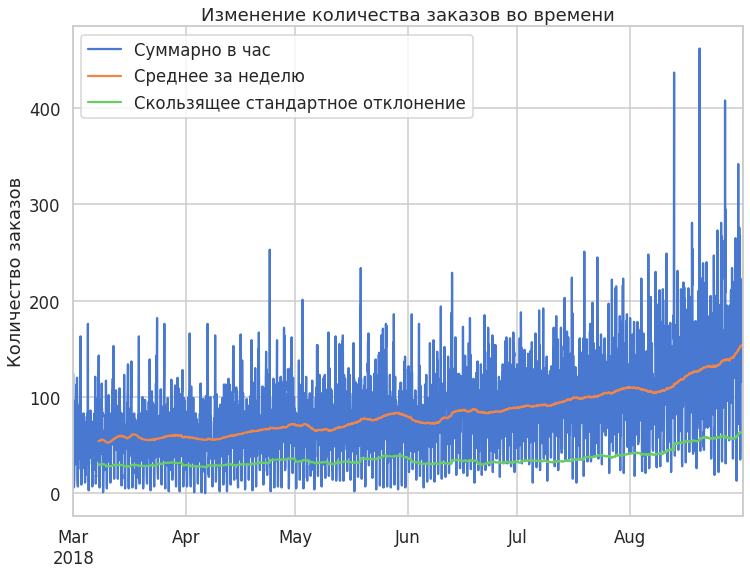

In [6]:
sns.set(context='talk', style='whitegrid', palette='muted')

plt.figure(figsize=(12, 9))

ax = df.plot(ax=plt.gca())
df.rolling(24 * 7).mean().plot(ax=ax)
df.rolling(24 * 7).std().plot(ax=ax)

plt.title('Изменение количества заказов во времени')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = ('Суммарно в час', 'Среднее за неделю', 'Скользящее стандартное отклонение'))
plt.show()

Видно, что количество заказов такси в аэропорт летом растёт и в августе становится существенно больше, чем в начале отпускного сезона. Посмотрим на августовский график отдельно. Размер скользящего окна установим в 24 часа, чтобы нивелировать неравномерный спрос в разное время суток и посмотреть на картину в масштабах месяца.

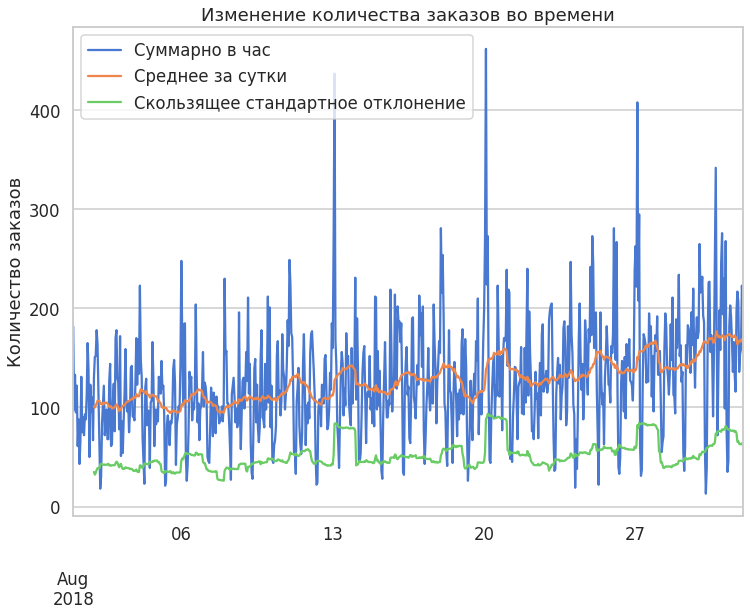

In [7]:
plt.figure(figsize=(12, 9))

ax = df['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
df['2018-08-01':'2018-08-31'].rolling(24).mean().plot(ax=ax)
df['2018-08-01':'2018-08-31'].rolling(24).std().plot(ax=ax)

plt.title('Изменение количества заказов во времени')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = ('Суммарно в час', 'Среднее за сутки', 'Скользящее стандартное отклонение'))
plt.show()

Есть три явных пика с интервалом в 7 дней. Возможно, взрослые возвращаются из отпусков перед началом рабочей недели, а школьники - в августе, чтобы успеть до 1 сентября. День недели и месяц - важные признаки для прогнозирования спроса.

Разложим временной ряд на тренд и сезонность.

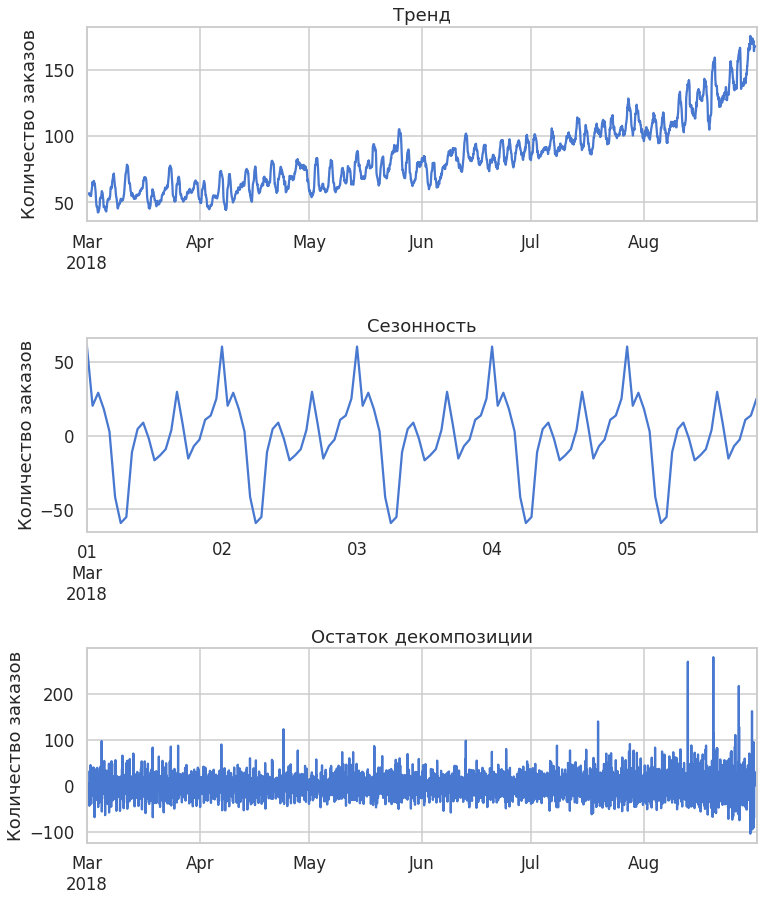

In [8]:
decomposed = seasonal_decompose(df)

f, ax = plt.subplots(3, gridspec_kw={'hspace': 0.6})
f.set_figheight(15)
f.set_figwidth(12)

decomposed.trend.plot(ax=ax[0])
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=ax[1])
decomposed.resid.plot(ax=ax[2])

ax[0].set_title('Тренд')
ax[1].set_title('Сезонность')
ax[2].set_title('Остаток декомпозиции')

for i in range(3):
    ax[i].set(xlabel='', ylabel='Количество заказов')
    ax[i].get_legend().remove()

plt.show()

Тренд на рост мы наблюдали и ранее. Сезонность показывает изменение спроса в течение суток. Час дня - ещё один важный признак для прогнозирования. Августовские пики seasonal_decompose отнёс к шуму в данных, но это не отменяет изменения спроса в течение недели.

Соотнесём график тренда со скользящим средним за сутки.

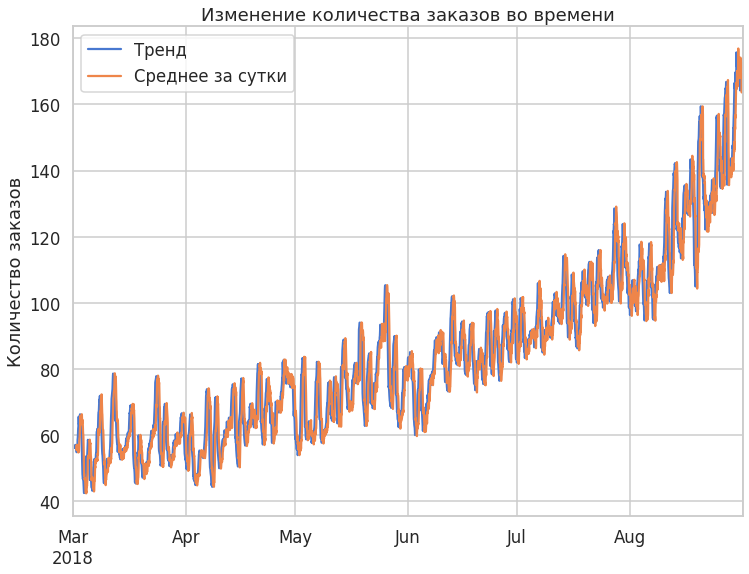

In [9]:
plt.figure(figsize=(12, 9))

ax = decomposed.trend.plot(ax=plt.gca())
df.rolling(24).mean().plot(ax=ax)

plt.title('Изменение количества заказов во времени')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = ('Тренд', 'Среднее за сутки'))
plt.show()

Графики практически совпадают. Скользящее среднее за сутки будет хорошим признаком для модели.

Посмотрим также на график разности временного ряда.

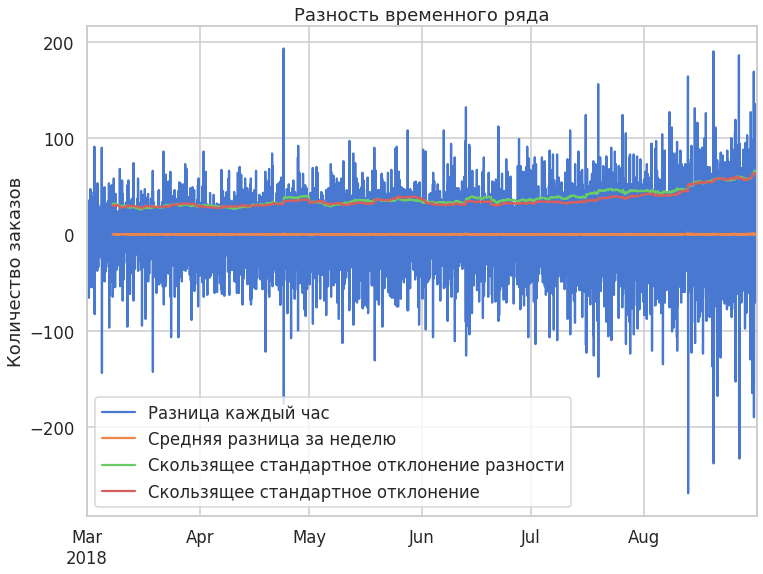

In [10]:
plt.figure(figsize=(12, 9))

ax = (df - df.shift()).plot(ax=plt.gca())
(df - df.shift()).rolling(24 * 7).mean().plot(ax=ax)
(df - df.shift()).rolling(24 * 7).std().plot(ax=ax)
df.rolling(24 * 7).std().plot(ax=ax)

plt.title('Разность временного ряда')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = (
    'Разница каждый час', 
    'Средняя разница за неделю', 
    'Скользящее стандартное отклонение разности',
    'Скользящее стандартное отклонение'
))
plt.show()

Если скользящее среднее в течение полугода растёт, то скользящее среднее разности - достаточно стабильная величина, близкая к нулю. При этом стандартное отклонение у разности практически совпадает со стандартным отклоением скользящего окна. В качестве признака хорошо будет добавить предыдущее значение временного ряда.

**Вывод**

Проведён анализ временного ряда. В течение представленного полугода тренд восходящий. Спрос на такси в аэропорт меняется в разное время суток, зависит от дня недели и растёт летом, показывая в августе наибольшие значения.

Важными для прогнозирования спроса признаками являются:
- *месяц*
- *день недели*
- *час дня*
- *значение за предыдущий час*
- *скользящее среднее за сутки*

## 3 Обучение

Создадим необходимые признаки. Строки в начале временного ряда, для которых невозможно посчитать значения, удалим из рассмотрения.

In [11]:
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df['prev_value'] = df['num_orders'].shift()
df['mean_24'] = df['num_orders'].shift().rolling(24).mean()
df = df.dropna()

Разделим ряд на обучающую и тестовую выборки.

In [12]:
X, X_test, y, y_test = train_test_split(
    df.drop('num_orders', axis=1), df['num_orders'], shuffle=False, test_size=0.1)

Для поиска гиперпараметров выделим валидационную выборку.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.1)

В качестве ориентира посчитаем RMSE для модели, которая использует вместо предсказанного значения значение за предыдущий час.

In [14]:
rmse_pv_valid = mean_squared_error(y_valid, y_valid.shift(fill_value=y_train.iloc[-1])) ** 0.5
print('Если прогнозировать предыдущим значением, RMSE = {:.1f}'.format(rmse_pv_valid))

Если прогнозировать предыдущим значением, RMSE = 47.3


Обучим линейную регрессию, посчитаем значение RMSE на валидационной выборке и переобучим эту модель на всех обучающих данных для финального тестирования. Такой алгоритм используем и для последующих моделей.

In [15]:
def fitting(model, refit=True):
    model.fit(X_train, y_train)
    rmse_valid = mean_squared_error(y_valid, model.predict(X_valid)) ** 0.5
    
    if refit:
        model.fit(X, y)
        
    return model, rmse_valid

model_lr = LinearRegression()
model_lr, rmse_lr_valid = fitting(model_lr)
print('Для линейной регрессии RMSE = {:.1f}'.format(rmse_lr_valid))

Для линейной регрессии RMSE = 41.0


Подберём лучшие гиперпараметры для случайного леса.

In [16]:
best_rmse = rmse_pv_valid

for est in range(150, 350, 30):
    for depth in range(10, 20, 2):
        model_rf = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=42)
        model_rf, rmse_rf_valid = fitting(model_rf, refit=False)
        if rmse_rf_valid < best_rmse:
            best_rmse = rmse_rf_valid
            best_est = est
            best_depth = depth
            
print('Лучшие параметры: n_estimators={}, max_depth={}'.format(best_est, best_depth))
print('Для случайного леса RMSE = {:.1f}'.format(best_rmse))

Лучшие параметры: n_estimators=240, max_depth=14
Для случайного леса RMSE = 32.3


Сохраним обученную модель и RMSE на валидационной выборке.

In [17]:
model_rf = RandomForestRegressor(n_estimators=best_est, max_depth=best_depth, random_state=42)
model_rf, rmse_rf_valid = fitting(model_rf)

Подберём лучшие гиперпараметры для градиентного бустинга.

In [18]:
best_rmse = rmse_pv_valid

for depth in range(4, 14, 2):
    for rate in np.arange(0.01, 0.1, 0.01):
        model_gb = XGBRegressor(
            n_estimators=1000, 
            max_depth=depth, 
            learning_rate=rate, 
            random_state=42,
            objective='reg:squarederror'
        )
        model_gb.fit(
            X_train, y_train, 
            early_stopping_rounds=5, 
            eval_set=[(X_valid, y_valid)], 
            eval_metric='rmse', 
            verbose=False
        )
        
        if model_gb.best_score < best_rmse:
            best_rmse = model_gb.best_score
            best_est = model_gb.best_iteration
            best_depth = depth
            best_rate = rate
            
print('Лучшие параметры: n_estimators={}, max_depth={}, learning_rate={}'.format(
    best_est, best_depth, best_rate))
print('Для градиентного бустинга RMSE = {:.1f}'.format(best_rmse))

Лучшие параметры: n_estimators=722, max_depth=6, learning_rate=0.01
Для градиентного бустинга RMSE = 31.8


Сохраним обученную модель и RMSE на валидационной выборке.

In [19]:
model_gb = XGBRegressor(
    n_estimators=best_est, 
    max_depth=best_depth, 
    learning_rate=best_rate, 
    random_state=42,
    objective='reg:squarederror'
)
model_gb, rmse_gb_valid = fitting(model_gb)

Сохраним полученные значения метрики в один датафрейм.

In [20]:
result = pd.DataFrame(
    {'RMSE_valid': [
        round(rmse_pv_valid, 1),
        round(rmse_lr_valid, 1),
        round(rmse_rf_valid, 1),
        round(rmse_gb_valid, 1)
    ]},
    index = [
        'PreviousValue',
        'LinearRegression',
        'RandomForestRegressor',
        'XGBRegressor'
    ]
)

**Вывод**

На основании проведённого анализа создано пять признаков:
- *month* - месяц;
- *day_of_week* - день недели;
- *hour* - час дня;
- *prev_value* - значение за предыдущий час;
- *mean_24* - среднее значение за предыдущие 24 часа.

Объекты с пропущенными значениями удалены, 10% данных выделены в тестовую выборку, оставшиеся 90% данных разделены на обучающую и валидационную выборки. 

Для модели, использующей в качестве предсказания значение за предыдущий час, рассчитано RMSE. 

Обучено три модели: линейная регрессия, случайный лес, градиентный бустинг. Для двух последних подобраны лучшие гиперпараметры из нескольких вариантов. Для каждой модели посчитано значение RMSE на валидационной выборке. Каждая модель переобучена на полном наборе обучающих данных.

In [21]:
result

,RMSE_valid
PreviousValue,47.3
LinearRegression,41.0
RandomForestRegressor,32.3
XGBRegressor,31.8


Лучшее значение RMSE на валидационной выборке показал градиентный бустинг.

## 4 Тестирование

Найдём RMSE на тестовых данных для каждой модели.

In [22]:
result.loc['PreviousValue', 'RMSE_test'] = round(
    mean_squared_error(y_test, y_test.shift(fill_value=y.iloc[-1])) ** 0.5,
    1)

result.loc['LinearRegression', 'RMSE_test'] = round(
    mean_squared_error(y_test, model_lr.predict(X_test)) ** 0.5,
    1)

result.loc['RandomForestRegressor', 'RMSE_test'] = round(
    mean_squared_error(y_test, model_rf.predict(X_test)) ** 0.5,
    1)

result.loc['XGBRegressor', 'RMSE_test'] = round(
    mean_squared_error(y_test, model_gb.predict(X_test)) ** 0.5,
    1)

(
    result.style
    .applymap(lambda x: 'color: red' if x > 48 else 'color:')
    .applymap(lambda x: 'border: 1px solid red' if x == result['RMSE_test'].min() else 'color:')
)

,RMSE_valid,RMSE_test
PreviousValue,47.3,58.9
LinearRegression,41,51.9
RandomForestRegressor,32.3,44.5
XGBRegressor,31.8,46.2


Разброс значений целевого признака в конце временного ряда - в августе - больше, чем на всём протяжении предыдущего времени, поэтому точность предсказания ниже. Для всех моделей значение RMSE ухудшилось. Лучшие показатели у случайного леса. Кроме того, у этой модели меньше разница между значениями метрик для валидационной и тестовой выборок, чем у градиентного бустинга.

Визуализируем предсказания случайного леса.

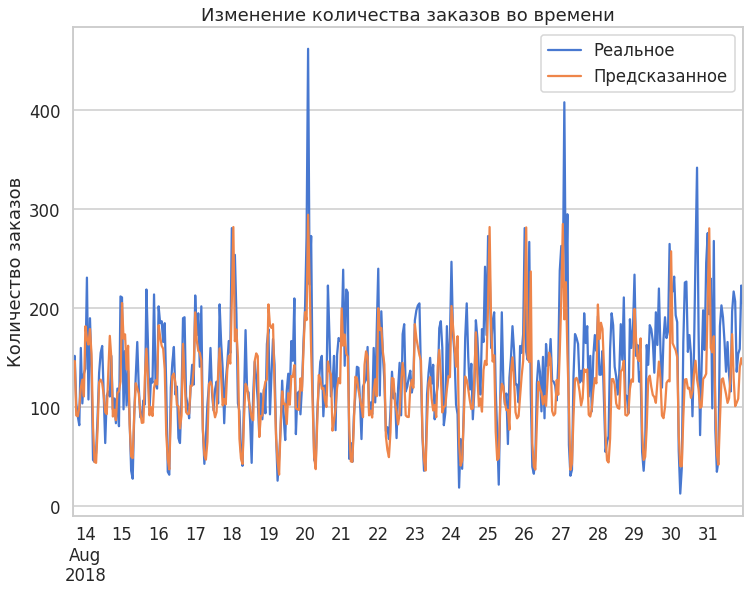

In [23]:
preds = pd.Series(model_rf.predict(X_test), index=X_test.index)

plt.figure(figsize=(12, 9))

ax = y_test.plot(ax=plt.gca())
preds.plot(ax=ax)

plt.title('Изменение количества заказов во времени')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.legend(labels = ('Реальное', 'Предсказанное'))
plt.show()

Видно, что в конце августа предсказания начинают сильнее расходиться с реальностью. Как показал анализ, в этот период времени стандартное отклонение тоже возрастает.

Посмотрим на важность признаков для случайного леса.

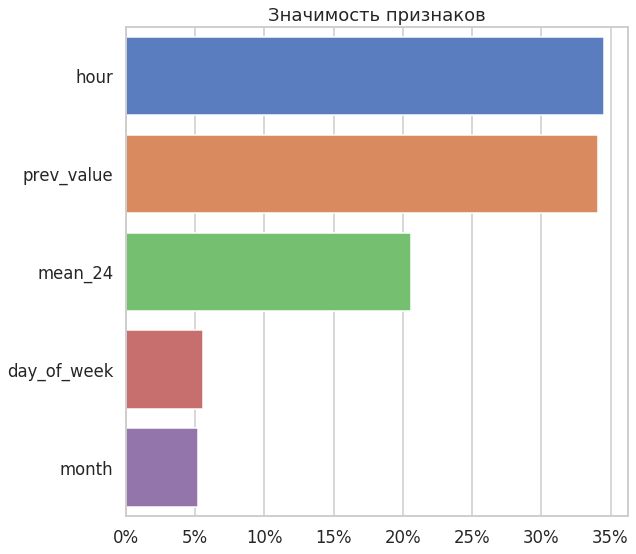

In [24]:
features = (
    pd.DataFrame({'feature': X.columns.values, 'value': model_rf.feature_importances_})
    .sort_values(by='value', ascending=False)
)

plt.figure(figsize=(9, 9))

ax = sns.barplot(
    x = 'value',
    y = 'feature',
    data = features
)

xlabels = ['{:.0%}'.format(x) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
plt.title('Значимость признаков')
plt.ylabel('')
plt.xlabel('')
plt.show()

**Вывод**

Отметку в 48 преодолели две модели: случайный лес и градиантный бустинг. Лучшее значение RMSE на тестовой выборке у случайного леса.

Наиболее значимыми признаками для случайного леса являются час дня и значение за предыдущий час, далее идёт среднее значение за предыдущие 24 часа. Фактически это показывает значимость сезонности и тренда.

## 5 Вывод

Данные загружены, ресемплированы и проанализированы. Построены графики временных зависимостей. Выделены признаки, влияющие на значение целевого признака:
- *месяц*
- *день недели*
- *час дня*
- *значение за предыдущий час*
- *скользящее среднее за сутки*

Данные разделены на тестовую и обучающую выборки. Для поиска оптимальных гиперпараметров выделена валидационная выборка. Обучено три модели: линейная регрессия, случайный лес и градиентный бустинг. Для двух последних моделей рассмотрено несколько гиперпараметров. Для каждой модели посчитано значение RMSE на валидационной и на тестовой выборке. Кроме того, метрика посчитана для варианта молели, возвращающей в качестве предсказания значение за предыдущий час.

На тестовой выборке все модели показали себя хуже, чем на валидационной. Это связано с тем, что в конце временного ряда разброс значений увеличивается. Линейная регрессия не преодолела порог RMSE=48. Лучшей моделью стал случайный лес: у него ниже значение RMSE, чем у градиентного бустинга, и меньше разница в значениях метрики для разных интервалов времени.

Наиболее важными параметрами для прогнозирования спроса на такси для случайного леса являются сезонность и тренд. 

## 6 Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48